We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Fetus EDA.

In [2]:
### DATA PREPARATION
fetus = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\fetal_health.csv')

df = pd.DataFrame(fetus)
df.rename(columns = {'baseline value': 'baseline_value'}, inplace = True)

df['fetal_health'] = df['fetal_health'].astype('category')

df.drop(['histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_width', 'histogram_min'], axis = 1, inplace = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of healthy, suspect and unhealthy fetuses.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df.drop(['fetal_health'], axis = 1)
y = df['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 123)

We now go on to make a simple Random Forest model, which will serve as our baseline. Remember that the data was highly unbalanced in that the number of normal fetuses was way more than fetuses which were either suspects or were unhealthy; fetuses with major health issues were only about 8%. To overcome this problem, we simply set the weights of the levels of y as balanced. What this does is that it assigns weights to the three levels of y, the weight of each level being inversely proportional to its frequency.

We also tell our model to calculate the Out-of-Bag score which will later help us to get the Out-of-bag error. The oob error is the proportion of data points which was left out during the process of bootstrapping while creating the random forest and was incorrectly labelled by those trees in the forest which did not consider them during their initial construction.

So, we build the model with class weights as balanced, fit it to the training data and plot the confusion matrix.

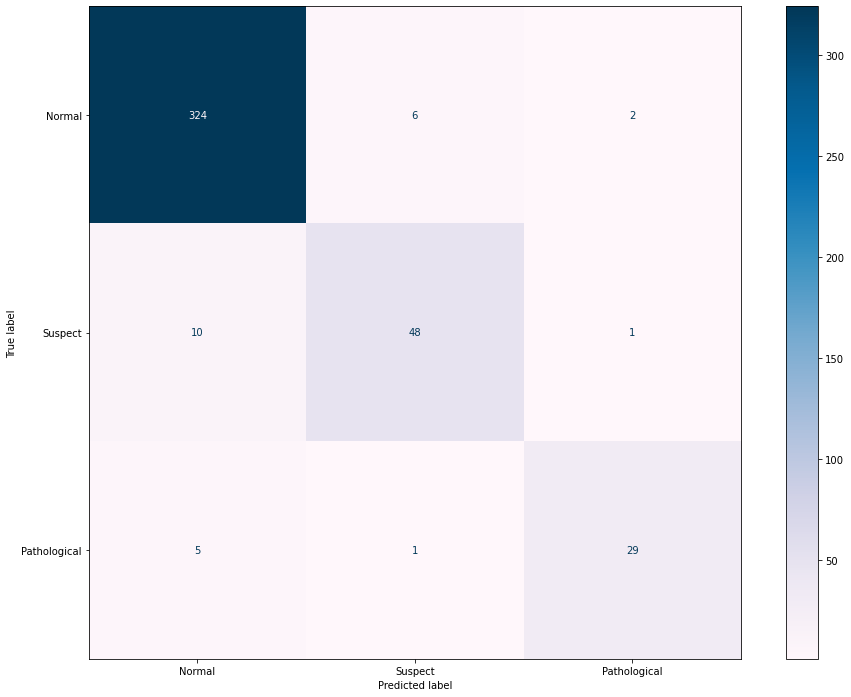

In [4]:
### CREATING A BASELINE MODEL
clf_rf = RandomForestClassifier(random_state = 123, class_weight = 'balanced', oob_score = True, n_jobs = -1)
clf_rf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (16, 12))
plot_confusion_matrix(clf_rf, X_test, y_test, display_labels = ['Normal', 'Suspect', 'Pathological'], ax = ax, cmap = plt.cm.PuBu)

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [5]:
df['fetal_health'].value_counts(normalize = True)

1.0    0.778457
2.0    0.138758
3.0    0.082785
Name: fetal_health, dtype: float64

Here, we see that around 78% of the fetuses in our dataset are normal as opposed to just about 14% which are suspects and about 8% which have health issues. This means that even if our model predicts every fetus as normal, the model will still be 78% accurate at the very least. So, in this case, accuracy is a deceptive metric.

What we should rather be concerned with is the number of fetuses that actually had major issues but were not identified by the model as having any i.e. the False Negatives for Pathological fetuses. The lower this FN value is, lower is the risk of overlooking a possible health issue and thus better is the model because the main objective of the model here should be to identify unhealthy fetuses. To reduce the FN value for Pathological fetuses, we need to ensure that the recall and F1 scores are high since recall and FN are inversely proportional and F1 is the harmonic mean of recall and precision.

So, we shall calculate the accuracy, recall and F1 values for the predictions made by the model. The parameter _'average'_ in the metrics is used for multiclass classifications like the present scenario. We shall set its value as _'weighted'_, which will calculate the metrics for each level and return their average weighted by the number of true samples in each level.

In [6]:
### CALCULATING ESSENTIAL METRICS
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_rf))
print('Recall score: %f' % recall_score(y_test, y_pred_rf, average = 'weighted'))
print('F1 score: %f' % f1_score(y_test, y_pred_rf, average = 'weighted'))
print('OOB error: %f' % (1 - clf_rf.oob_score_))

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       332
         2.0       0.87      0.81      0.84        59
         3.0       0.91      0.83      0.87        35

    accuracy                           0.94       426
   macro avg       0.91      0.87      0.89       426
weighted avg       0.94      0.94      0.94       426

Accuracy: 0.941315
Recall score: 0.941315
F1 score: 0.940382
OOB error: 0.064118


If we look at the confusion matrix, we see that out of the 35 fetuses that actually had major issues, 29 were correctly predicted as having one by our model while 1 was said to be a suspect and the remaining 5 were deemed normal. Also, of the 59 suspected fetuses, 48 were correctly identified while 10 were deemed as being normal. This gives us a recall score of about 94.1%, an F1 score of about 94% and an accuracy of about 94.1%. Also, the OOB error is about 6.4%.


Random Forest also allows us to look at the variables that it considers important to the final outcome.

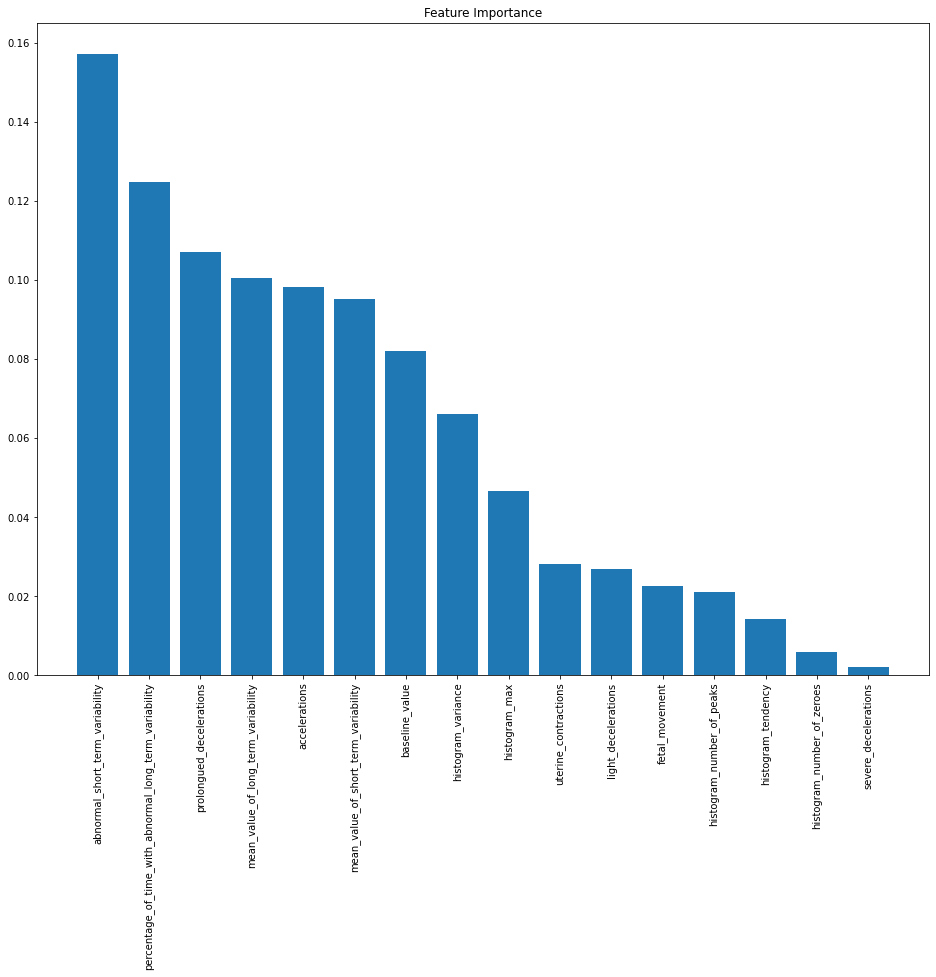

In [7]:
### PLOTTING FEATURE IMPORTANCE
importance = clf_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that _'abnormal_short_term_variability'_, _'percentage_of_time_with_abnormal_long_term_variability'_ and _'prolongued_decelerations'_ are respectively the top three features which are considered to be important by the model. This may be due to the range of their values being larger than others which may have led to overfitting.

Next, we will try to further improve the model by tuning it's hyperparameters. For this, we shall use random search with 5 fold cross-validation across the possible values for the following hyperparameters:

1. n_estimators: the number of trees in the forest
2. max_depth: the maximum number of levels in each tree in the forest
3. max_features: the maximum number of features to be considered while making a tree
4. min_samples_leaf: the minimum number of samples required to consider a node as a leaf
5. min_samples_split: the minimum number of samples required to further split a node


We will use f1_weighted as our scoring parameter.

In [8]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(2, 20),
    'max_features': range(2, 15),
    'min_samples_leaf': range(5, 20),
    'min_samples_split': range(5, 20)
}
clf = RandomForestClassifier(random_state = 123, class_weight = 'balanced', oob_score = True, n_jobs = -1)
random_fit = RandomizedSearchCV(estimator = clf, 
                               param_distributions = param_distributions,
                               scoring = 'f1_weighted',
                               cv = 5,
                               n_iter = 30,
                               random_state = 123,
                               verbose = 2,
                               n_jobs = -1)
random_fit.fit(X_train, y_train)
print('Best F1 score: %f' % random_fit.best_score_)
print(random_fit.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished


Best F1 score: 0.921060
{'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 9}


Now, with these tuned hyperparameter values, we shall create our final Random Forest model.

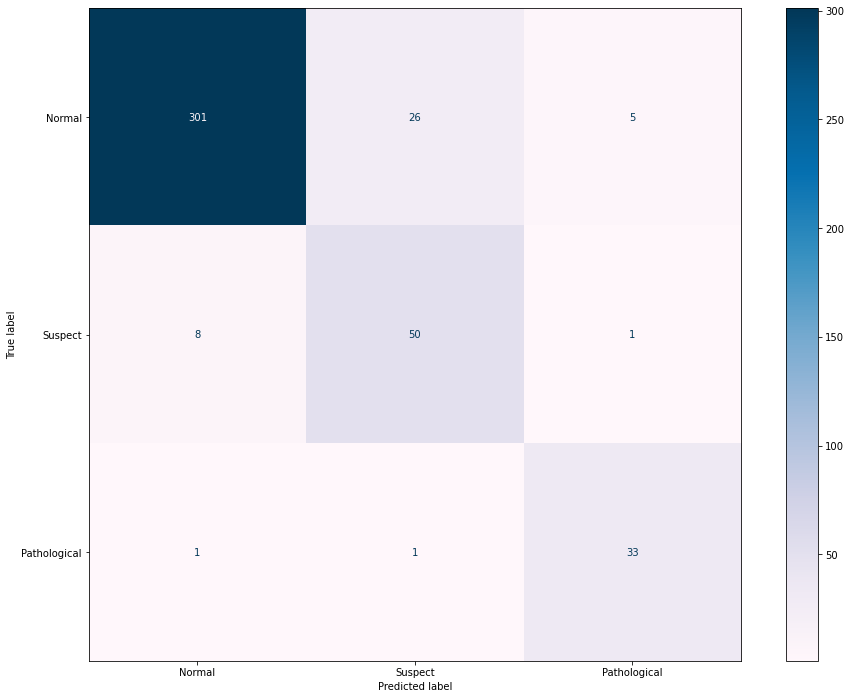

In [9]:
### CREATING THE FINAL MODEL
clf_rf = RandomForestClassifier(random_state = 123, 
                                class_weight = 'balanced', 
                                n_estimators = 300,
                                min_samples_split = 16,
                                min_samples_leaf = 5,
                                max_features = 6,
                                max_depth = 9,
                                oob_score = True, 
                                n_jobs = -1)
clf_rf.fit(X_train, y_train)
fig, ax = plt.subplots(figsize = (16, 12))
plot_confusion_matrix(clf_rf, X_test, y_test, display_labels = ['Normal', 'Suspect', 'Pathological'], ax = ax, cmap = plt.cm.PuBu)

If we look at the confusion matrix, we see that out of the 35 fetuses that actually had major issues, 33 were correctly predicted as having one by our final model while the previous model had only predicted 29 correctly. Also, of the 59 suspected fetuses, 50 were correctly identified(48 by the previous model) while 8(10 by the previous model) were deemed as being normal.

In [10]:
### CALCULATING ESSENTIAL METRICS
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_rf))
print('Recall score: %f' % recall_score(y_test, y_pred_rf, average = 'weighted'))
print('F1 score: %f' % f1_score(y_test, y_pred_rf, average = 'weighted'))
print('OOB error: %f' % (1 - clf_rf.oob_score_))

              precision    recall  f1-score   support

         1.0       0.97      0.91      0.94       332
         2.0       0.65      0.85      0.74        59
         3.0       0.85      0.94      0.89        35

    accuracy                           0.90       426
   macro avg       0.82      0.90      0.85       426
weighted avg       0.92      0.90      0.91       426

Accuracy: 0.901408
Recall score: 0.901408
F1 score: 0.905900
OOB error: 0.085294


We have a recall score of about 90.1%, an F1 score of about 91% and an accuracy of about 90.1%. Also, the OOB error is about 8.5%. All of these metrics tell us that the final model may be worse than the initial one but what we must consider is the objective of the models. Since the main motive behind building these models is to correctly identify any major defect in fetuses, we should compare the total number of suspected and fatal cases that were correctly identified by them. Since the final model does a much better job at predicting such cases than the initial one, thus, even though the intial model is far better at predicting the normal cases, we shall consider the final Random Forest model as the best one.

We can also see which features the final Random Forest model considers significant.

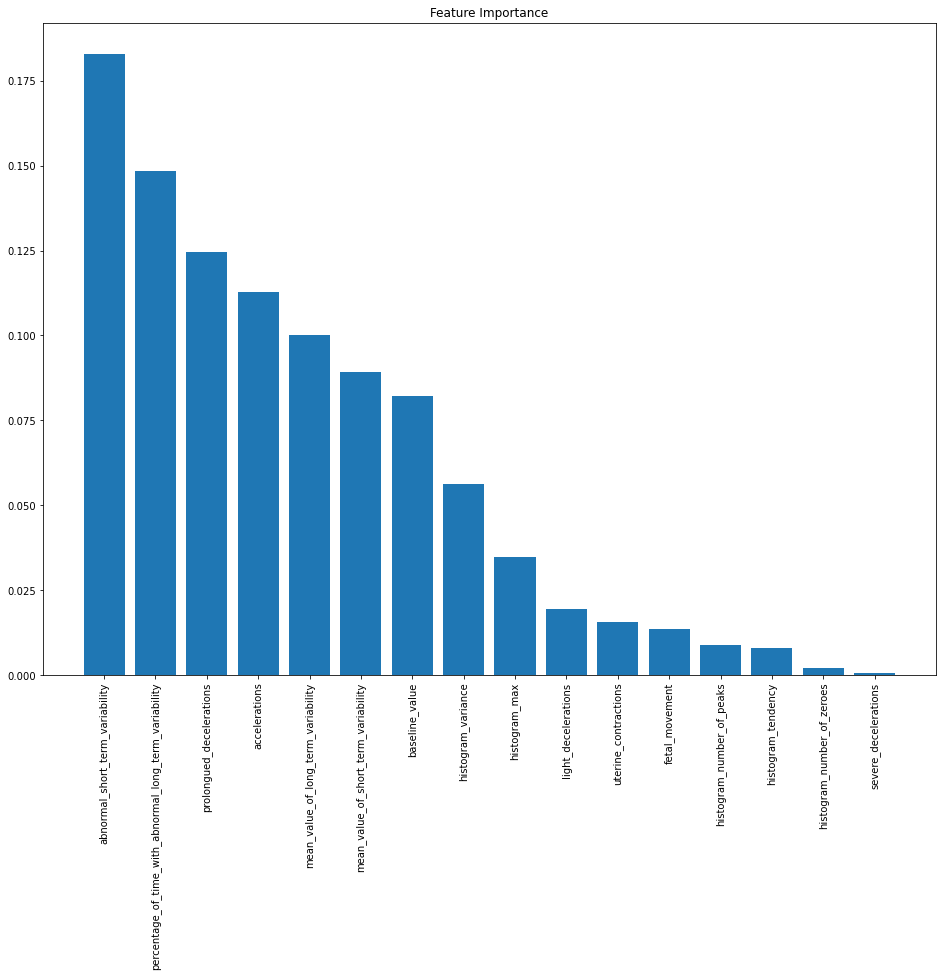

In [11]:
### PLOTTING FEATURE IMPORTANCE
importance = clf_rf.feature_importances_
indices = np.argsort(importance)[::-1]
names = [X.columns[i] for i in indices]
plt.figure(figsize = (16, 12))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), names, rotation = 90)
plt.show()

We see that, just like in the initial model, the features 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability' and 'prolongued_decelerations' are respectively the top three ones which are considered to be important by the final Random Forest model.